In [23]:
# =======================
# 1. Importing Libraries
# =======================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
import optuna

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Bidirectional
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [25]:
# =======================
# 2. Load and Explore Dataset
# =======================
df = pd.read_csv('Paitients_Files_Train.csv')

# Display basic info
print("First 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nRandom sample of 5 rows:")
print(df.sample(5))
print("\nData Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nSummary Statistics (Numerical):")
print(df.describe())
print("\nSummary Statistics (Categorical):")
print(df.describe(include=['object']))


First 5 rows:
          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

Last 5 rows:
            ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
594  ICU200604    6  123  72  45  230  33.6  0.733   34          0  Negative
595  ICU200605    0  188  82  14  185  32.0  0.682   22          1  Positive
596  ICU200606    0   67  76   0    0  45.3  0.194   46          1  Negative
597  ICU200607    1   89  24  19   25  27.8  0.559   21          0  Negative
598  ICU200608    1  173  74   0    0  36.8  0.088   38          1  Positive

Random sample of 5 rows:
            ID  PRG   PL  PR  SK  

In [27]:
# =======================
# 3. Handle Missing Values & Invalid Zeros
# =======================
# Replace zeros with NaN for specified columns where zero is invalid
cols_with_invalid_zeros = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2']
for col in cols_with_invalid_zeros:
    df.loc[df[col] == 0, col] = np.nan

print("\nSummary after replacing zeros with NaN:")
print(df[cols_with_invalid_zeros].describe())
print("\nMissing values per column:")
print(df.isnull().sum())

# Impute missing values using median strategy
cols_to_impute = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11']
imputer = SimpleImputer(strategy='median')
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

print("\nMissing values after imputation:")
print(df[cols_to_impute].isnull().sum())
print("\nUpdated summary statistics for imputed columns:")
print(df[cols_to_impute].describe())


Summary after replacing zeros with NaN:
              PRG          PL          PR          SK          TS         M11  \
count  506.000000  594.000000  571.000000  424.000000  310.000000  590.000000   
mean     4.527668  121.164983   72.103327   29.049528  153.538710   32.406949   
std      3.194089   30.893218   12.197850   10.750992  122.023594    7.021781   
min      1.000000   44.000000   24.000000    7.000000   14.000000   18.200000   
25%      2.000000   99.000000   64.000000   21.000000   74.000000   27.325000   
50%      4.000000  116.500000   72.000000   29.000000  120.000000   32.000000   
75%      7.000000  140.750000   80.000000   36.000000  190.000000   36.600000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2  
count  599.000000  
mean     0.481187  
std      0.337552  
min      0.078000  
25%      0.248000  
50%      0.383000  
75%      0.647000  
max      2.420000  

Missing values per column:
ID             0
PRG 

In [29]:
# =======================
# 4. Remove Duplicates
# =======================
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")


Number of duplicate rows: 0


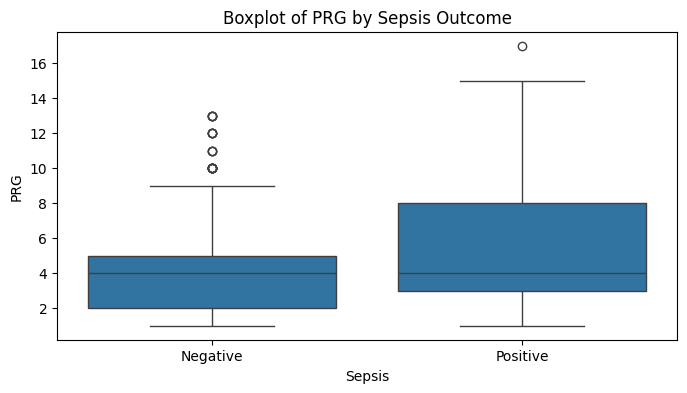

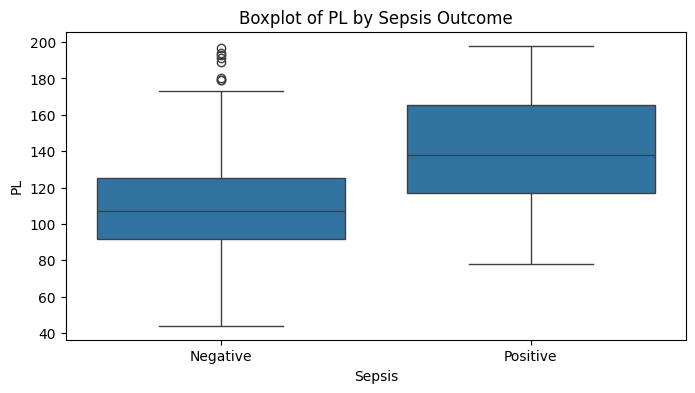

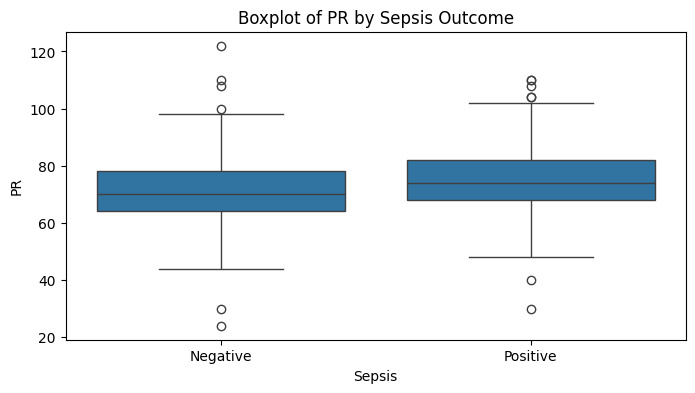

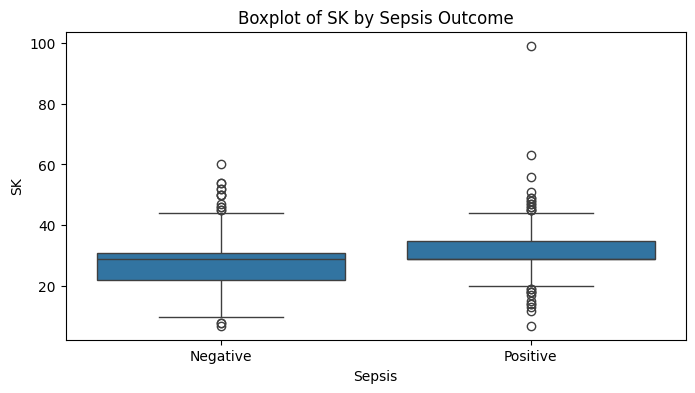

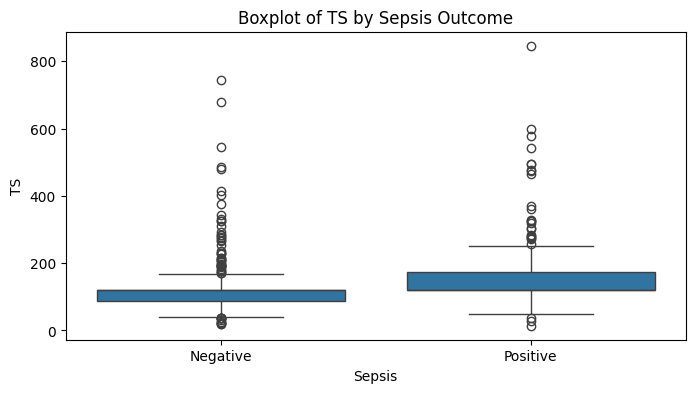

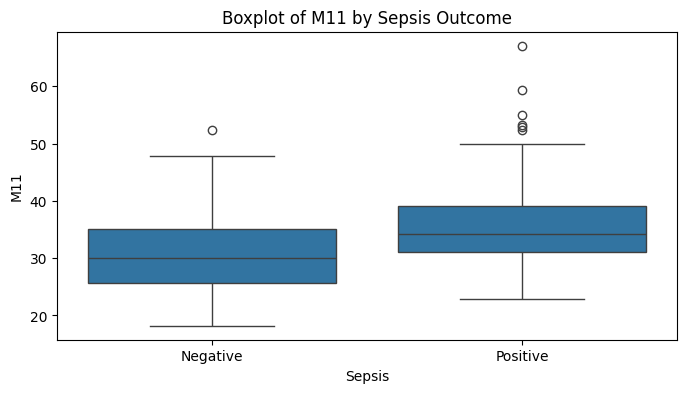

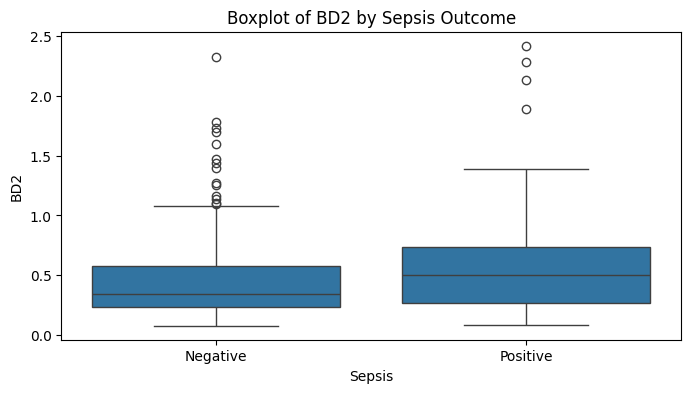

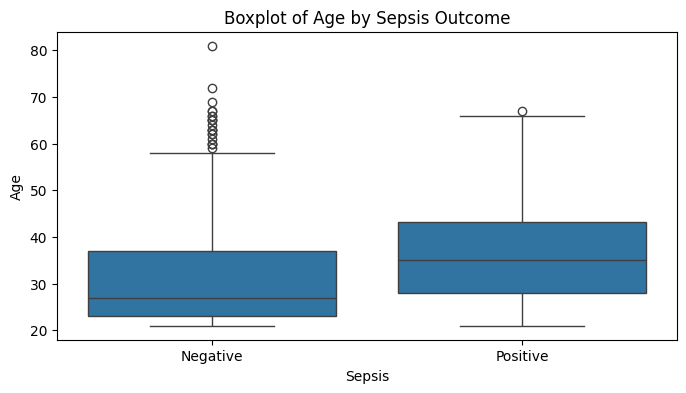

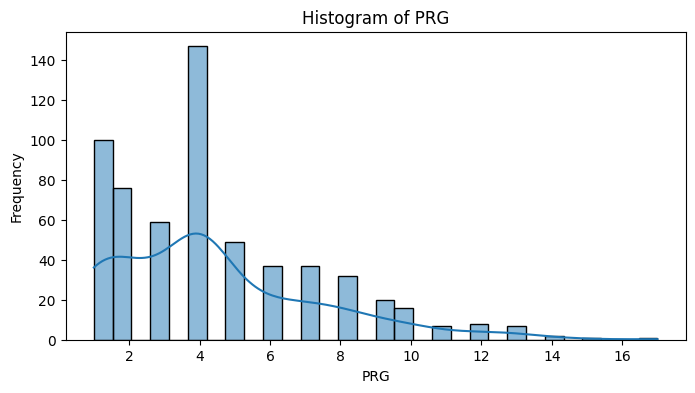

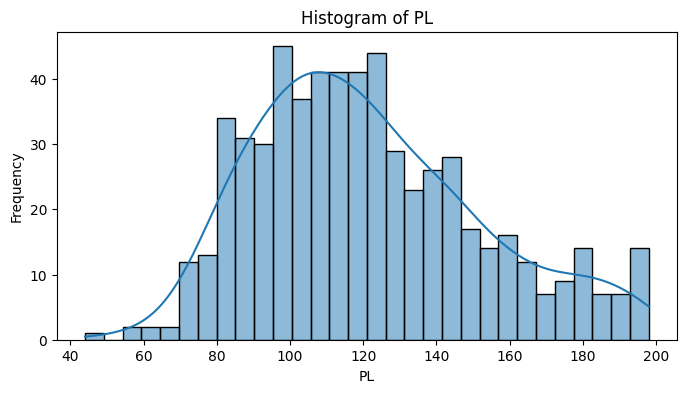

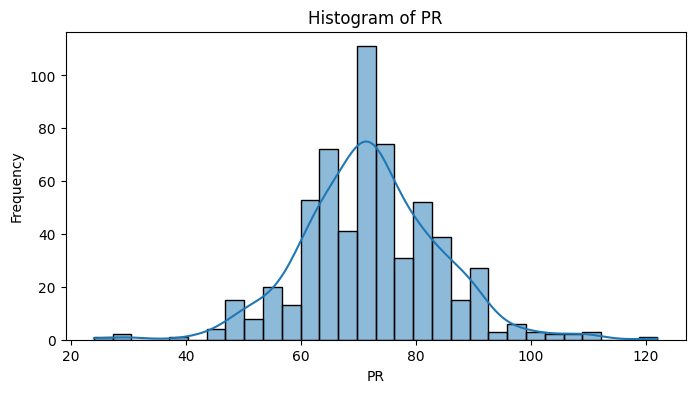

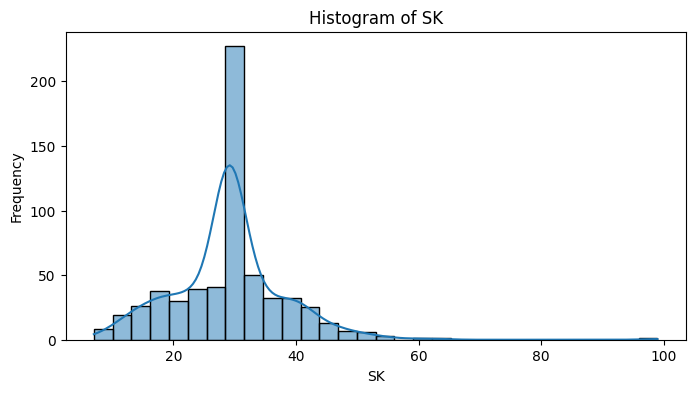

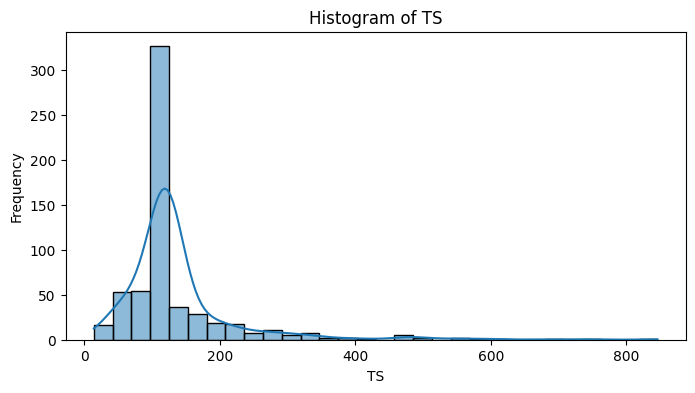

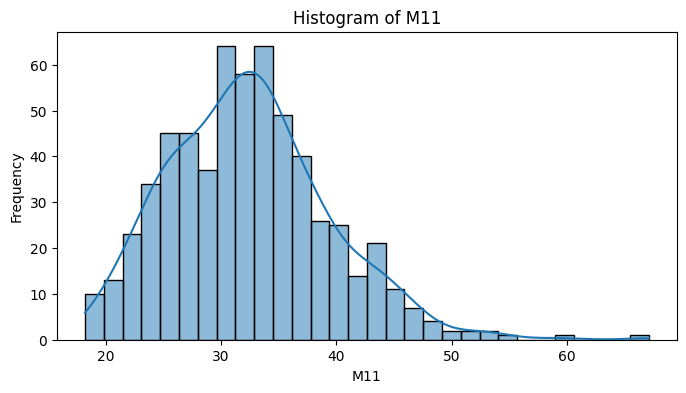

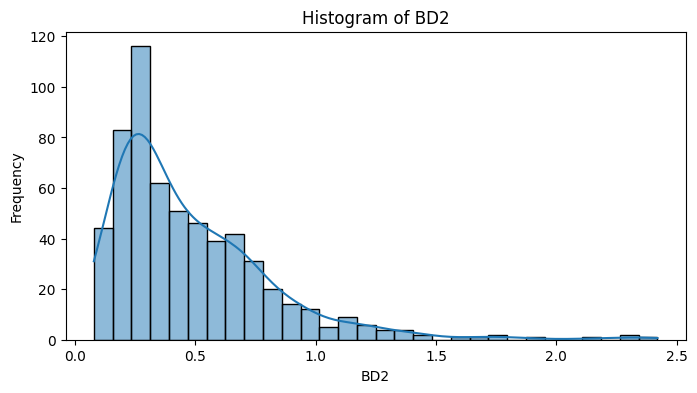

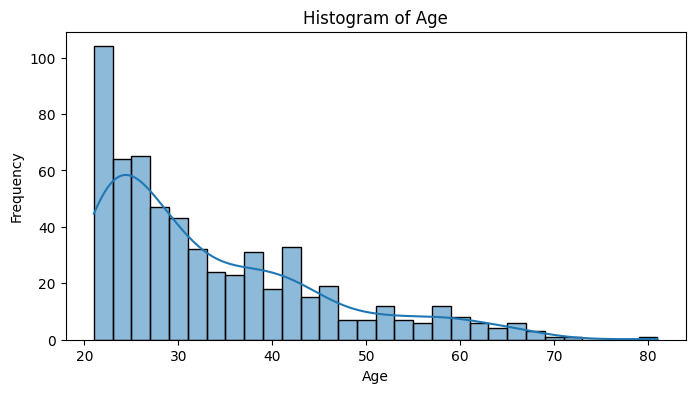

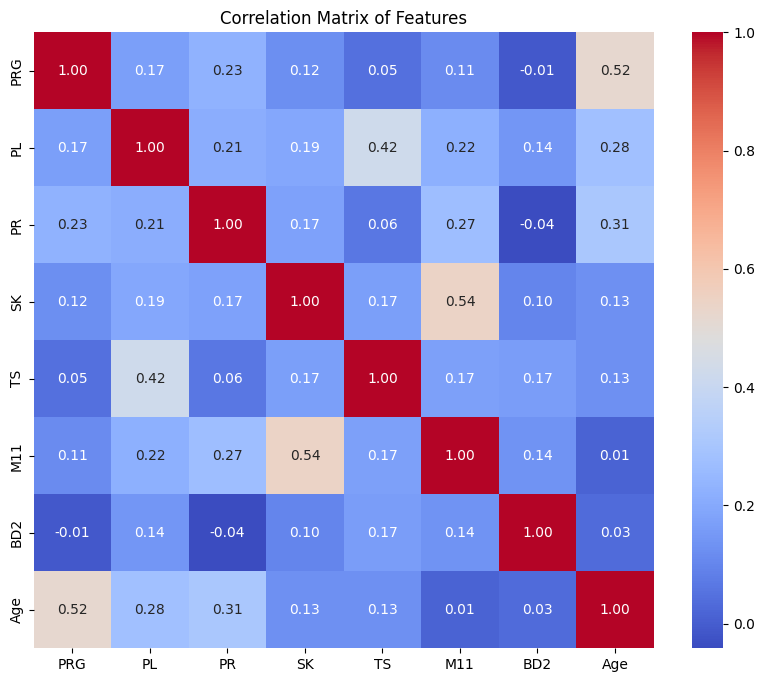

All plots have been saved into eda_results.pdf


In [31]:
# =======================
# 5. Exploratory Data Analysis (EDA)
# =======================
# Define features and target for EDA
features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']
target = 'Sepssis'

# For EDA, ensure target is categorical (if not already)
df[target] = df[target].astype('category')

# Boxplots by sepsis outcome
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Sepsis Outcome')
    plt.xlabel('Sepsis')
    plt.ylabel(feature)
    plt.show()

# Histograms with KDE for each feature
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Correlation heatmap for continuous features
corr_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# (Optional) Save plots to PDF
from matplotlib.backends.backend_pdf import PdfPages
pdf_filename = 'eda_results.pdf'
with PdfPages(pdf_filename) as pdf:
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.boxplot(x=target, y=feature, data=df, ax=ax)
        ax.set_title(f'Boxplot of {feature} by Sepsis Outcome')
        pdf.savefig(fig)
        plt.close(fig)
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.histplot(df[feature], kde=True, bins=30, ax=ax)
        ax.set_title(f'Histogram of {feature}')
        pdf.savefig(fig)
        plt.close(fig)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title('Correlation Matrix of Features')
    pdf.savefig(fig)
    plt.close(fig)
print(f"All plots have been saved into {pdf_filename}")

In [33]:
# =======================
# 6. Hypothesis Testing
# =======================
# Convert target to binary: map 'Negative' -> 0 and 'Positive' -> 1
df[target] = df[target].map({'Negative': 0, 'Positive': 1})

from scipy.stats import ttest_ind, mannwhitneyu

def choose_test(series):
    # Use t-test if skewness is small
    return abs(series.skew()) < 0.5

results = []
for feature in features:
    group0 = df[df[target] == 0][feature]
    group1 = df[df[target] == 1][feature]
    
    if choose_test(group0) and choose_test(group1):
        test_stat, p_value = ttest_ind(group0, group1, nan_policy='omit')
        test_used = 't-test'
    else:
        test_stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
        test_used = 'Mann-Whitney U'
    
    results.append({
        'Feature': feature,
        'Test': test_used,
        'Statistic': test_stat,
        'p-value': p_value
    })
results_df = pd.DataFrame(results)
print("\nHypothesis Testing Results:")
print(results_df)


Hypothesis Testing Results:
  Feature            Test     Statistic       p-value
0     PRG  Mann-Whitney U  29045.500000  5.517151e-09
1      PL  Mann-Whitney U  17463.500000  1.233922e-30
2      PR          t-test     -4.182297  3.318872e-05
3      SK  Mann-Whitney U  30292.500000  1.737963e-07
4      TS  Mann-Whitney U  26883.500000  3.404875e-13
5     M11  Mann-Whitney U  24763.000000  3.134672e-15
6     BD2  Mann-Whitney U  31589.500000  6.800959e-06
7     Age  Mann-Whitney U  26491.500000  1.971962e-12


In [35]:
# =======================
# 7. Data Transformation & Scaling
# =======================
# Apply PowerTransformer (Yeo-Johnson) on selected features
for col in ["SK", "TS", "M11", "BD2", "Age"]:
    transformer = PowerTransformer(method='yeo-johnson')
    df[col] = transformer.fit_transform(df[[col]])

# Drop an identifier column if present
if "ID" in df.columns:
    df.drop(columns=["ID"], inplace=True)

# Separate features and target.
# (Make sure not to include the target in scaling!)
X = df.drop(columns=[target])
Y = df[target].astype(int)  # Ensure target is integer

# Use RobustScaler on the features
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("\nScaled Features Preview:")
print(X_scaled.head())



Scaled Features Preview:
    PRG        PL     PR        SK        TS       M11       BD2       Age  \
0  0.50  0.768293  0.000  0.818876  0.000000  0.169826  0.525864  0.853995   
1 -0.75 -0.768293 -0.375  0.000000  0.000000 -0.637210 -0.092184  0.133688   
2  1.00  1.621951 -0.500  0.000000  0.000000 -1.087712  0.597409  0.194025   
3 -0.75 -0.670732 -0.375 -0.888094 -3.434720 -0.449105 -0.787872 -0.800685   
4  0.00  0.500000 -2.000  0.818876  4.708344  1.046598  1.501376  0.250558   

   Insurance  
0       -1.0  
1       -1.0  
2        0.0  
3        0.0  
4        0.0  


In [37]:
# =======================
# 8. Train/Test Split and SMOTE
# =======================
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, stratify=Y
)

# Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Logistic Regression AUC Score: 0.8193

Logistic Regression Accuracy: 0.7333
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        78
           1       0.59      0.79      0.67        42

    accuracy                           0.73       120
   macro avg       0.72      0.75      0.72       120
weighted avg       0.76      0.73      0.74       120



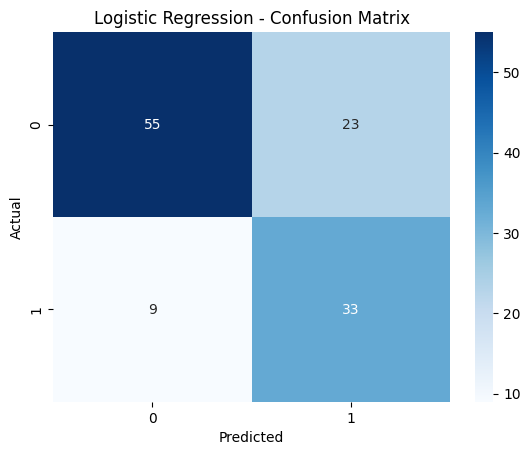


Random Forest AUC Score: 0.8193

Random Forest Accuracy: 0.7333
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        78
           1       0.61      0.64      0.63        42

    accuracy                           0.73       120
   macro avg       0.71      0.71      0.71       120
weighted avg       0.74      0.73      0.73       120



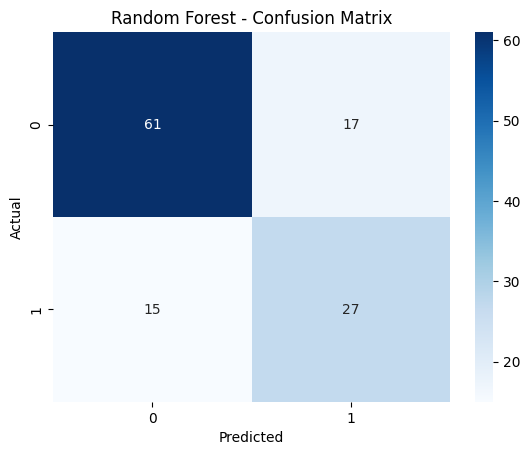


SVM AUC Score: 0.7885

SVM Accuracy: 0.6917
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        78
           1       0.54      0.74      0.63        42

    accuracy                           0.69       120
   macro avg       0.68      0.70      0.68       120
weighted avg       0.73      0.69      0.70       120



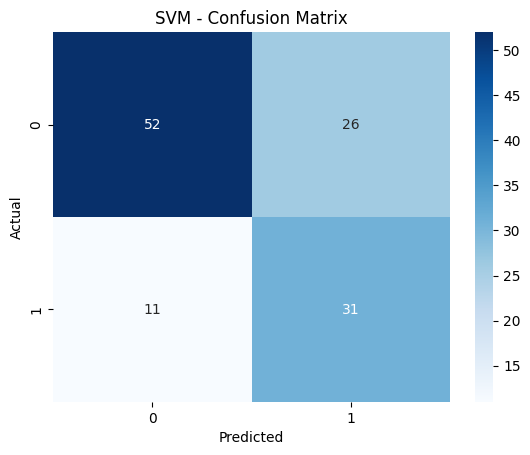

In [39]:
# =======================
# 9. Model Training and Evaluation
# =======================
# Define a helper function for evaluation
def evaluate_model(model, X_tst, y_tst, model_name="Model"):
    y_pred = model.predict(X_tst)
    print(f"\n{model_name} Accuracy: {accuracy_score(y_tst, y_pred):.4f}")
    print(classification_report(y_tst, y_pred))
    cm = confusion_matrix(y_tst, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# -- Basic Models using SMOTE-resampled training data --
basic_models = {
    "Logistic Regression": LogisticRegression(solver="saga", class_weight="balanced", max_iter=5000),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "SVM": SVC(probability=True, class_weight="balanced")
}

for name, model in basic_models.items():
    model.fit(X_train_res, y_train_res)
    # Use predict_proba for AUC if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print(f"\n{name} AUC Score: {auc:.4f}")
    evaluate_model(model, X_test, y_test, model_name=name)



Stacking Model Accuracy: 0.7333
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        78
           1       0.61      0.64      0.63        42

    accuracy                           0.73       120
   macro avg       0.71      0.71      0.71       120
weighted avg       0.74      0.73      0.73       120



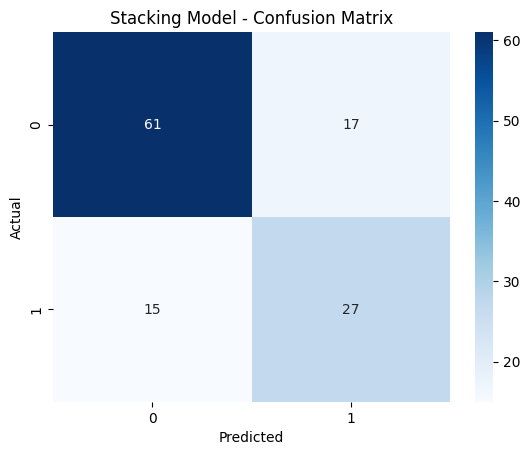

In [41]:
# -- Stacking Model Example --
from sklearn.ensemble import StackingClassifier
stack_base_models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]
stack_meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=stack_base_models, final_estimator=stack_meta_model)
stacking_model.fit(X_train_res, y_train_res)
evaluate_model(stacking_model, X_test, y_test, model_name="Stacking Model")

# -- Additional Models without SMOTE (for comparison) --
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, stratify=Y
)


Gradient Boosting Accuracy: 0.7333
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        78
           1       0.62      0.60      0.61        42

    accuracy                           0.73       120
   macro avg       0.71      0.70      0.70       120
weighted avg       0.73      0.73      0.73       120



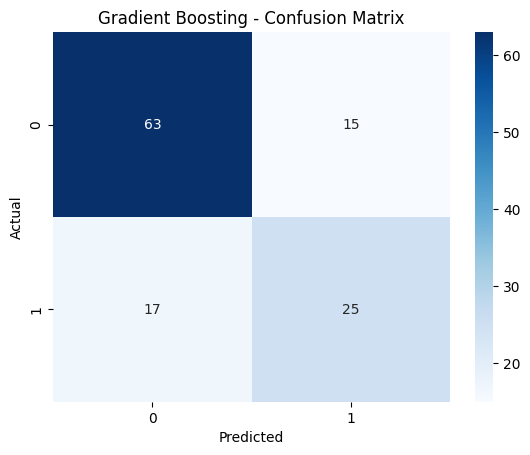

C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.7083
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        78
           1       0.58      0.62      0.60        42

    accuracy                           0.71       120
   macro avg       0.68      0.69      0.68       120
weighted avg       0.71      0.71      0.71       120



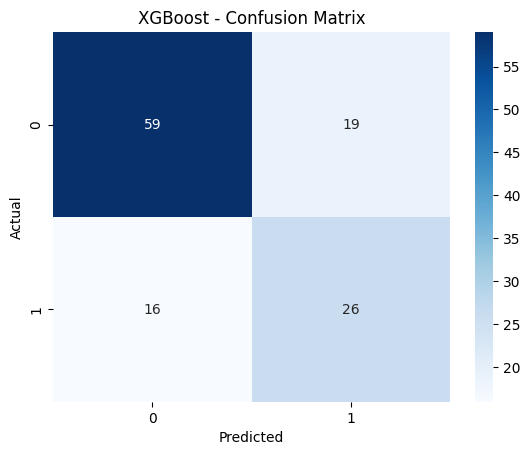


KNN Accuracy: 0.7000
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        78
           1       0.57      0.62      0.59        42

    accuracy                           0.70       120
   macro avg       0.67      0.68      0.68       120
weighted avg       0.71      0.70      0.70       120



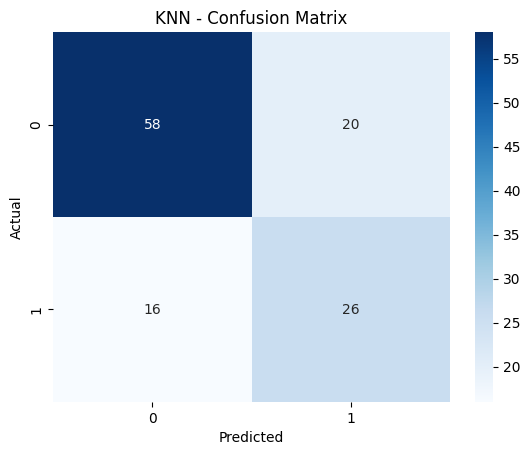

C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP (Simple NN) Accuracy: 0.6750
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        78
           1       0.53      0.57      0.55        42

    accuracy                           0.68       120
   macro avg       0.65      0.65      0.65       120
weighted avg       0.68      0.68      0.68       120



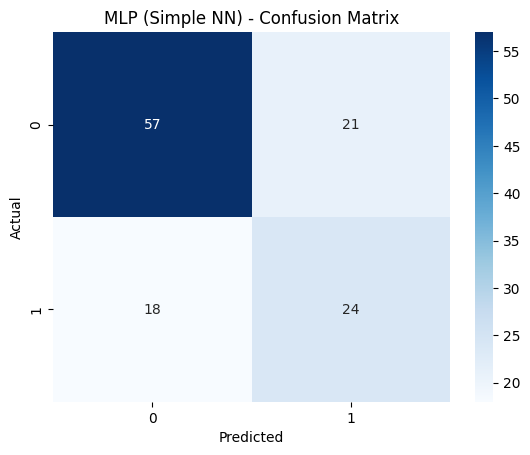


MLP (Deeper NN) Accuracy: 0.6833
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        78
           1       0.55      0.57      0.56        42

    accuracy                           0.68       120
   macro avg       0.65      0.66      0.66       120
weighted avg       0.69      0.68      0.68       120



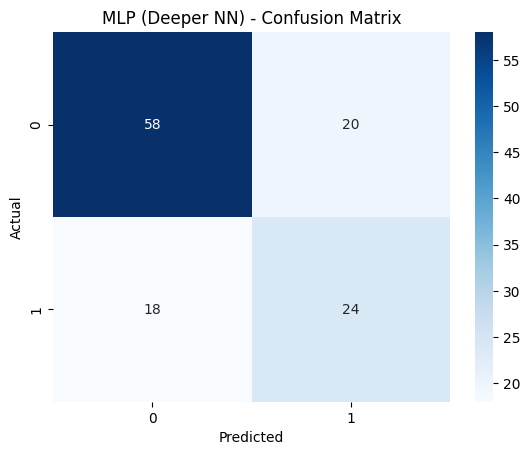

C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

RNN Model Evaluation:
0.7
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        78
           1       0.57      0.60      0.58        42

    accuracy                           0.70       120
   macro avg       0.67      0.68      0.67       120
weighted avg       0.70      0.70      0.70       120



C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Bidirectional RNN Model Evaluation:
0.7416666666666667
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        78
           1       0.67      0.52      0.59        42

    accuracy                           0.74       120
   macro avg       0.72      0.69      0.70       120
weighted avg       0.73      0.74      0.73       120



In [43]:
# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_ns, y_train_ns)
evaluate_model(gb_model, X_test_ns, y_test_ns, model_name="Gradient Boosting")

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_ns, y_train_ns)
evaluate_model(xgb_model, X_test_ns, y_test_ns, model_name="XGBoost")

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_ns, y_train_ns)
evaluate_model(knn_model, X_test_ns, y_test_ns, model_name="KNN")

# MLP (Simple NN)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_model.fit(X_train_ns, y_train_ns)
evaluate_model(mlp_model, X_test_ns, y_test_ns, model_name="MLP (Simple NN)")

# MLP (Deeper NN)
mlp_deep_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500)
mlp_deep_model.fit(X_train_ns, y_train_ns)
evaluate_model(mlp_deep_model, X_test_ns, y_test_ns, model_name="MLP (Deeper NN)")

# -- RNN Models --
# Reshape data for RNN: [samples, timesteps, features]
X_train_rnn = np.reshape(X_train_ns.values, (X_train_ns.shape[0], X_train_ns.shape[1], 1))
X_test_rnn = np.reshape(X_test_ns.values, (X_test_ns.shape[0], X_test_ns.shape[1], 1))

# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_rnn, y_train_ns, epochs=10, verbose=0)
rnn_pred = (rnn_model.predict(X_test_rnn) > 0.5).astype(int)
print("\nRNN Model Evaluation:")
print(accuracy_score(y_test_ns, rnn_pred))
print(classification_report(y_test_ns, rnn_pred))

# Bidirectional RNN Model
bi_rnn_model = Sequential([
    Bidirectional(SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], 1))),
    Dense(1, activation='sigmoid')
])
bi_rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bi_rnn_model.fit(X_train_rnn, y_train_ns, epochs=10, verbose=0)
bi_rnn_pred = (bi_rnn_model.predict(X_test_rnn) > 0.5).astype(int)
print("\nBidirectional RNN Model Evaluation:")
print(accuracy_score(y_test_ns, bi_rnn_pred))
print(classification_report(y_test_ns, bi_rnn_pred))

[I 2025-04-04 21:10:17,428] A new study created in memory with name: no-name-46350862-3674-429e-8f8e-3de011849027
C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-04 21:10:18,374] Trial 0 finished with value: 0.7416666666666667 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.25734960113740124, 'subsample': 0.6917558937646072, 'colsample_bytree': 0.9143892838617453}. Best is trial 0 with value: 0.7416666666666667.
C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parame


Best Parameters from Optuna: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.059611312073299616, 'subsample': 0.7365650674462608, 'colsample_bytree': 0.8383960331187639}


C:\Users\dines\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Optimized XGBoost Model Evaluation:

Optimized XGBoost Accuracy: 0.7583
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        78
           1       0.64      0.69      0.67        42

    accuracy                           0.76       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.76      0.76      0.76       120



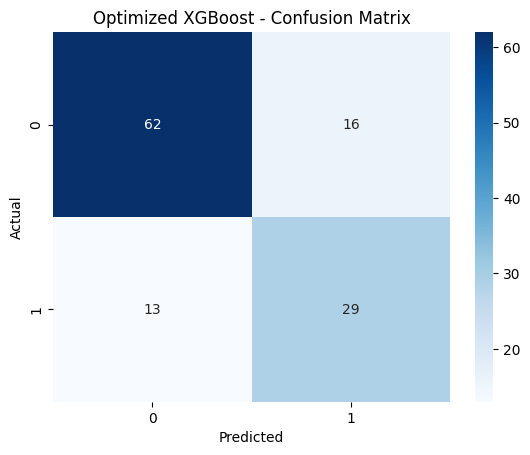

In [45]:
# =======================
# 10. Optuna Hyperparameter Optimization for XGBoost
# =======================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_ns, y_train_ns)
    preds = model.predict(X_test_ns)
    return accuracy_score(y_test_ns, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("\nBest Parameters from Optuna:", best_params)

best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train_ns, y_train_ns)
best_preds = best_xgb.predict(X_test_ns)
print("\nOptimized XGBoost Model Evaluation:")
evaluate_model(best_xgb, X_test_ns, y_test_ns, model_name="Optimized XGBoost")

In [49]:
import pickle

# Save the model to a file
with open('optimized_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

print("Model saved to 'optimized_xgb_model.pkl'")


Model saved to 'optimized_xgb_model.pkl'
